In [1]:
import numpy as np
import tensorflow as tf


# to read the training data and making use of vocabulary and index the chars:
# To read the training data and make a vocabulary and dictiornary to index the chars
class DataReader:
    def __init__(self, path, seq_length):
        #uncomment below , if you dont want to use any file for text reading and comment next 2 lines
        #self.data = "some really long text to test this. maybe not perfect but should get you going."
        self.fp = open(path, "r")
        self.data = self.fp.read()
        #find unique chars
        chars = list(set(self.data))
        #create dictionary mapping for each char
        self.char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
        self.ix_to_char = {i:ch for (i,ch) in enumerate(chars)}
        #total data
        self.data_size = len(self.data)
        #num of unique chars
        self.vocab_size = len(chars)
        self.pointer = 0
        self.seq_length = seq_length

    def next_batch(self):
        input_start = self.pointer
        input_end = self.pointer + self.seq_length
        inputs = [self.char_to_ix[ch] for ch in self.data[input_start:input_end]]
        targets = [self.char_to_ix[ch] for ch in self.data[input_start+1:input_end+1]]
        self.pointer += self.seq_length
        if self.pointer + self.seq_length + 1 >= self.data_size:
            # reset pointer
            self.pointer = 0
        return inputs, targets

    def just_started(self):
        return self.pointer == 0

    def close(self):
        self.fp.close()
        


In [2]:
from d2l import tensorflow as d2l
import math
import numpy as np
import tensorflow as tf

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

train_random_iter, vocab_random_iter = d2l.load_data_time_machine(
    batch_size, num_steps, use_random_iter=True)

In [3]:
fp = open("temp.txt", "r")
data = fp.read()
#find unique chars
chars = list(set(data))
#create dictionary mapping for each char
char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
ix_to_char = {i:ch for (i,ch) in enumerate(chars)}

inputs = [char_to_ix[ch] for ch in data[0:10]]
targets = [char_to_ix[ch] for ch in data[1:11]]

In [4]:
def get_params(vocab_size, num_hidden):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    # Hidden layer parameters
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

In [5]:
def init_rnn_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )

In [6]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
#         print("input",X.shape)
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        a = tf.matmul(X, W_xh)
        b = tf.matmul(H, W_hh)
        print("a", a.shape)
        H = tf.tanh(a + b + b_h)
        Y = tf.matmul(H, W_hq) + b_q
#         print("Yshape",Y.shape)
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)

In [7]:
class RNNModelScratch: #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn


    def __call__(self, X, state, params):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, params)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

In [8]:
def train_epoch_ch8(model, updater,  #@save
                    params, data_reader, seq_len):
    """Train a model within one epoch (defined in Chapter 8)."""
    state = None
#     metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens

    threshold =0.05
    lr=1
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    updater = tf.keras.optimizers.SGD(lr)
    optimizer = tf.keras.optimizers.Adam()
    loss_res=[]
    loss_epochs=[]
    epochs=10
    metric = d2l.Accumulator(2)
    timer=d2l.Timer()
    while epochs>0:
        loss_per_epoch=0
        while True:
            
            inputs, target = data_reader.next_batch()

            X = tf.reshape(tf.Variable(inputs), (1, seq_len))
            Y_out= tf.reshape(tf.Variable(target), (1, seq_len))


            if state is None:
                # Initialize `state` when either it is the first iteration or
                # using random sampling
                state = model.begin_state(batch_size=X.shape[0])
            with tf.GradientTape(persistent=True) as g:
                g.watch(params)
                y_hat, state= model(X, state, params)
                y = tf.reshape(Y_out, (-1))
    #             print(y_hat)
                l = tf.math.reduce_mean(loss(y, y_hat))
            grads = g.gradient(l, params)
            grads = grad_clipping(grads, 1)
#             updater.apply_gradients(zip(grads, params))
            optimizer.apply_gradients(zip(grads, params))
    #         tf.print('Current Loss', l)
            metric.add(l * tf.size(y).numpy(), tf.size(y).numpy())
            if data_reader.pointer==0:
                loss_per_epoch=l
                break
        loss_epochs.append(loss_per_epoch)
        # Keras loss by default returns the average loss in a batch
        # l_sum = l * float(tf.size(y).numpy()) if isinstance(
        #     loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        loss_res.append(math.exp(metric[0] / metric[1]))
        epochs=epochs-1
    return loss_res, loss_epochs

In [27]:
def grad_clipping(grads, theta): #@save
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in grads))
    norm = tf.cast(norm, tf.float32)
    new_grad = []
    if tf.greater(norm, theta):
        for grad in grads:
            new_grad.append(grad * theta / norm)
    else:
        for grad in grads:
            new_grad.append(grad)
    return new_grad

In [ ]:
num_hiddens = 1024
seq_len=10
lr=0.1
updater = tf.keras.optimizers.SGD(lr)
data_reader = DataReader("temp.txt", seq_len)
#defining the required params:
params = get_params(data_reader.vocab_size, num_hiddens)
model=RNNModelScratch(data_reader.vocab_size, num_hiddens, init_rnn_state, rnn)

loss_res, loss_epochs=train_epoch_ch8(model, updater, params, data_reader, seq_len)

In [4]:
def get_params2(vocab_size, num_hidden):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    # Hidden layer parameters
    E = tf.Variable(normal((vocab_size, 10)), dtype=tf.float32)
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    M = tf.Variable(tf.random.uniform([W_xh.shape[1], vocab_size], dtype=tf.float32))
    params = [W_xh, W_hh, b_h, W_hq, b_q, E, M]
    return params

In [5]:
def my_func(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [6]:
def init_rnn_state2(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )

In [7]:
def rnn2(inputs, state, params, curr_sent, vocab_size, word2vec_model):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q, E, M = params
    
    # calculating the values from the encoder function
    result=tf.zeros([vocab_size, 1], tf.float32)
    for every_char in curr_sent:
        tfcharEmb = my_func(word2vec_model[every_char])
        tfcharEmb=tf.reshape(tfcharEmb, [10, 1])
        result+= tf.matmul(E, tfcharEmb)
        
#     M=tf.random.uniform([W_xh.shape[1], vocab_size], dtype=tf.float32)
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
#         print("input",X.shape)
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        a= tf.matmul(X, W_xh)
        b= tf.matmul(H, W_hh)
        c = tf.matmul(M, result)
        c =  tf.reshape(c, [c.shape[1], c.shape[0]])
        H = tf.tanh(a + b + b_h + c)
        Y = tf.matmul(H, W_hq) + b_q
#         print("Yshape",Y.shape)
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)


In [8]:
class RNNModelScratch2: #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens,
                 init_state, forward_fn, word2vec):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn
        self.word2vec=word2vec

    def __call__(self, X, state, params, curr_sent):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, params, curr_sent, self.vocab_size, self.word2vec)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)
    

In [9]:
def train(model, params, data_reader, sentences, char_to_ix, ix_to_char):
    "traing the modified model"
    state=None
    
    threshold = 0.05
    lr=1
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    updater = tf.keras.optimizers.SGD(lr)
    optimizer = tf.keras.optimizers.Adam()
    loss_res=[] # storage for the resultant loss
    loss_epochs = [] #keeping of the loss per epoch
    epochs = 2400
    metric = d2l.Accumulator(2)
    timer=d2l.Timer()
    
    
    while epochs>0:
        
        loss_per_epoch=0
        
        for every_sent in sentences:
            temp_sent = every_sent.split()
            index = random.randint(0, len(temp_sent)-1)
            
            # definging the target word:
            target_word = temp_sent[index]
            curr_train_sent = ""
            for ind, word in enumerate(temp_sent):
                if ind==index:
                    pass
                else:
                    curr_train_sent+=word+" "
            #padding the current word
            target_word = "$"+target_word+"$"
            
            input_str = target_word[0:len(target_word)-1]
            target_str = target_word[1:len(target_word)]
            
            inputs = [char_to_ix[ch] for ch in input_str]
            targets = [char_to_ix[ch] for ch in target_str]
            
            X = tf.reshape(tf.Variable(inputs), (1, len(inputs)))
            Y_out= tf.reshape(tf.Variable(targets), (1, len(targets)))
            
            
            # The actual crux of training the data:
            
            if state is None:
                
                state = model.begin_state(batch_size=X.shape[0])
                
            with tf.GradientTape(persistent=True) as g:
                print('I am here 1')
                g.watch(params)
                y_hat, state= model(X, state, params, curr_train_sent)
                y = tf.reshape(Y_out, (-1))
                
                # calculating the loss
                l = tf.math.reduce_mean(loss(y, y_hat))
            
            print('I am here 2')
            grads = g.gradient(l, params)
            grads = grad_clipping(grads, 1)
            optimizer.apply_gradients(zip(grads, params))
#             updater.apply_gradients(zip(grads, params))
            print('I am here 3')
            metric.add(l * tf.size(y).numpy(), tf.size(y).numpy())
            loss_per_epoch=l
            
        # after every epoch
        loss_epochs.append(loss_per_epoch)
        loss_res.append(math.exp(metric[0] / metric[1]))
        epochs=epochs-1
    return loss_epochs, loss_res

            
        

In [10]:
from gensim.models import Word2Vec
import nltk, os
import tensorflow as tf
import itertools
import random

In [11]:
def filter_words(sentence):
    ll = [[nltk.word_tokenize(w), ' '] for w in sentence.split()]
#     print(list(itertools.chain(*list(itertools.chain(*ll)))))
#     return [word.lower() if word.isalpha() else " " for word in [nltk.word_tokenize(sentence), " "]]
    return list(itertools.chain(*list(itertools.chain(*ll))))

def tokenize(text):
    return [filter_words(sentence) for sentence in nltk.sent_tokenize(text)]





In [12]:
fp = open("temp.txt", "r")
data = fp.read()
#find unique chars
chars = list(set(data))
#create dictionary mapping for each char
char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
ix_to_char = {i:ch for (i,ch) in enumerate(chars)}

lines = data
sentences=lines.split('\n')

tokenized_words=[]
sent_data=[]
for sentence in sentences:
    sent_mod=''
    for char in sentence:
        sent_mod+=char+' ' 
#     print(sent_mod)
#     print(nltk.sent_tokenize(sent_mod))
    tokenized_words.extend(tokenize(sent_mod))
    sent_data.append(sentence)

word2vec_model = Word2Vec(tokenized_words, 
                          sg=1,  # here we will use skipgram 0 is for CBROW; skip gram is for smaller models 
                          size=10,
                          min_count=1 # word needs to occur atleast once
                         )

num_hiddens = 256
lr=0.1
seq_len=10
updater = tf.keras.optimizers.SGD(lr)
data_reader = DataReader("temp.txt", seq_len)
#defining the required params:
params = get_params2(len(chars), num_hiddens)


In [14]:
model=RNNModelScratch2(len(chars), num_hiddens, init_rnn_state2, rnn2, word2vec_model)
loss_res, loss_epochs=train(model, params, data_reader, sentences, char_to_ix, ix_to_char)



I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1


/Users/kedargn94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am here 2
I am here 3
I am here 1
I am

In [13]:
def grad_clipping(grads, theta): #@save
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in grads))
    norm = tf.cast(norm, tf.float32)
    new_grad = []
    if tf.greater(norm, theta):
        for grad in grads:
            new_grad.append(grad * theta / norm)
    else:
        for grad in grads:
            new_grad.append(grad)
    return new_grad

In [103]:
loss_epochs

[<tf.Tensor: shape=(), dtype=float32, numpy=2.8602138>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.9655502>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0032547>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0460458>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0364082>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.994141>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0716124>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.980577>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.9778285>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.9727445>]

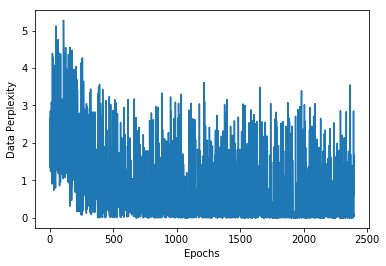

In [15]:
import matplotlib.pyplot as plt
plt.plot(loss_res)
plt.ylabel('Data Perplexity')
plt.xlabel('Epochs')
plt.show()

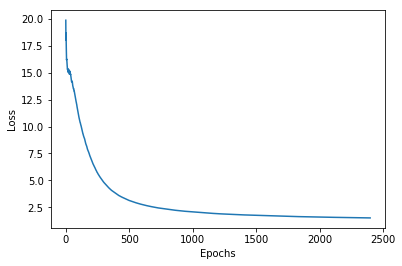

In [17]:
import matplotlib.pyplot as plt
plt.plot(loss_epochs)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

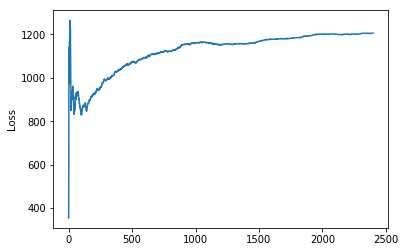

In [84]:
import matplotlib.pyplot as plt
plt.plot(loss_epochs)
plt.ylabel('Loss')
plt.show()

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/Users/kedargn94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


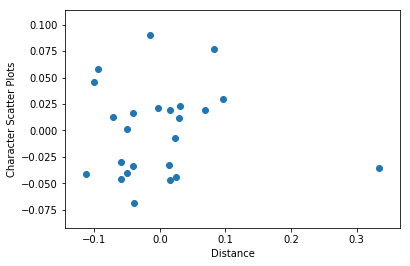

In [19]:
# Get the model from the file:
vocab = word2vec_model.wv.vocab

# instantiate the pca object
pca = PCA(n_components=2)

# Fit and transform the PCA object
pca_model = pca.fit_transform(word2vec_model[vocab])
plt.xlabel('Distance')
plt.ylabel('Character Scatter Plots')
# plot the data:
plt.scatter(pca_model[:,0], pca_model[:,1])

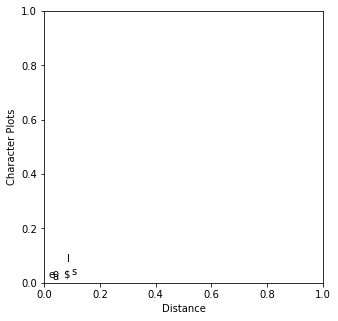

In [20]:
# annotating the plot
plt.figure(figsize=(5,5))
plt.xlabel('Distance')
plt.ylabel('Character Plots')

for i, word in enumerate(vocab):
    plt.annotate(word, xy=(pca_model[i, 0], pca_model[i, 1]))
    
plt.show()

In [22]:
def keep_only_alnum(sentence):
    return [element for element in nltk.word_tokenize(sentence) if element.isalnum()]

def tokenize(text):
    return [keep_only_alnum(line) for line in nltk.sent_tokenize(text.lower())]  

In [23]:
file_sherlock_to_play = "temp.txt"
data= open(file_sherlock_to_play, 'rt')

lines = data.read()
sentences=lines.split('\n')

tokenized_words=[]
sent_data=[]


for sentence in sentences:
    tokenized_words.extend(tokenize(sentence))
    sent_data.append(sentence)




In [24]:

word2vec = Word2Vec(tokenized_words, 
                          sg=1,  # here we will use skipgram 0 is for CBROW; skip gram is for smaller models 
                          size=10,
                          min_count=1 # word needs to occur atleast once
                         )



/Users/kedargn94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


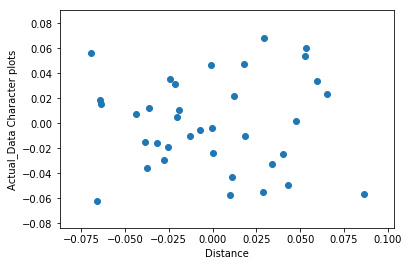

In [25]:
# Get the model from the file:
vocab = word2vec.wv.vocab

# instantiate the pca object
pca = PCA(n_components=2)

# Fit and transform the PCA object
pca_model = pca.fit_transform(word2vec[vocab])
plt.xlabel('Distance')
plt.ylabel('Actual_Data Character plots')

# plot the data:
plt.scatter(pca_model[:,0], pca_model[:,1])

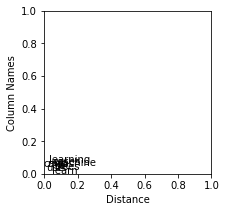

In [26]:
# annotating the plot
plt.figure(figsize=(3,3))
plt.xlabel('Distance')
plt.ylabel('Column Names')

for i, word in enumerate(vocab):
    plt.annotate(word, xy=(pca_model[i, 0], pca_model[i, 1]))
    
plt.show()